In [47]:
import os 
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
#load in training data. We will use this as both train and test, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})
drop_cols = [col for col in data.columns if 'retrieval' in col]
data = data.drop(columns=drop_cols)
drop_cols = ['giver_username_if_known', 'request_id', 'requester_username']
data = data.drop(columns=drop_cols)
                 
#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)
                 
y = data['target']
X = data.drop(columns=['target'])

#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')

Roughly 25% of requests receive pizza.


In [98]:
def eval_model(X, plot_importance = False):
    X = X.select_dtypes(np.number)
    y = data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
    scores = cross_val_score(baseline_clf, X_train, y_train, cv=5)
    print(f'CV Model Accuracy: {round(np.mean(scores), 4) * 100}%')
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    
    print('Out of Sample Performance:')
    print(metrics.confusion_matrix(yhat, y_test))
    print(metrics.classification_report(yhat, y_test))

    if plot_importance == True:
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        feature_names = list(X.columns)
        forest_importances = pd.Series(importances, index=feature_names)

        fig, ax = plt.subplots(figsize=(10,10))
        forest_importances.plot.barh(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()

    
def test_transformation(X, transformer):
    X = X.select_dtypes(np.number)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    X_train = transformer.fit_transform(X_train)

    #Default randomforest with cross validation
    clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Model accuracy w {str(transformer)}: {round(np.mean(scores), 4) * 100}%')
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print('Out of Sample Performance:')
    print(metrics.classification_report(yhat, y_test))
    print('-------------------------\n')

CV Model Accuracy: 76.05%
Out of Sample Performance:
[[976 281]
 [ 30  47]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1257
           1       0.14      0.61      0.23        77

    accuracy                           0.77      1334
   macro avg       0.56      0.69      0.55      1334
weighted avg       0.92      0.77      0.83      1334

Calibrated Performance:
[[966 272]
 [ 40  56]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1238
           1       0.17      0.58      0.26        96

    accuracy                           0.77      1334
   macro avg       0.57      0.68      0.56      1334
weighted avg       0.90      0.77      0.82      1334



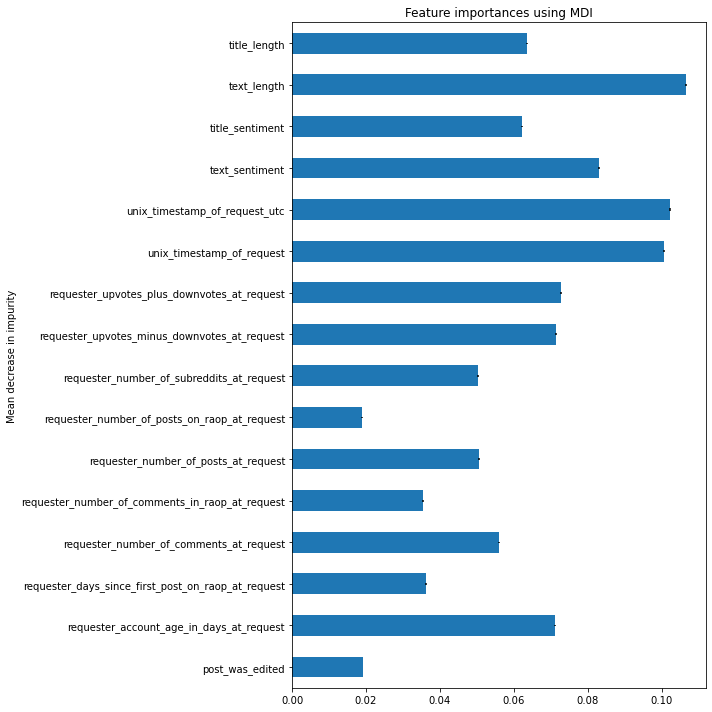

In [99]:
eval_model(X, plot_importance = True)

In [69]:
transformers = [
    preprocessing.StandardScaler(),
    preprocessing.Normalizer(),
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.PowerTransformer(method = 'yeo-johnson')
]

for transformer in transformers:
    test_transformation(X, transformer)

Model accuracy w StandardScaler(): 74.83%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1257
           1       0.09      0.36      0.14        77

    accuracy                           0.74      1334
   macro avg       0.52      0.56      0.49      1334
weighted avg       0.90      0.74      0.80      1334

-------------------------

Model accuracy w Normalizer(): 75.31%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model accuracy w MinMaxScaler(): 74.83%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1135
           1       0.19      0.32      0.24       199

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.53      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------

Model accuracy w MaxAbsScaler(): 74.94%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1135
           1       0.19      0.32      0.24       199

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.53      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Model accuracy w PowerTransformer(): 75.76%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1267
           1       0.08      0.37      0.13        67

    accuracy                           0.74      1334
   macro avg       0.52      0.57      0.49      1334
weighted avg       0.91      0.74      0.81      1334

-------------------------



CV Model Accuracy: 76.05%
Out of Sample Performance:
[[981 281]
 [ 25  47]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1262
           1       0.14      0.65      0.23        72

    accuracy                           0.77      1334
   macro avg       0.56      0.72      0.55      1334
weighted avg       0.93      0.77      0.83      1334

Calibrated Performance:
[[967 273]
 [ 39  55]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1240
           1       0.17      0.59      0.26        94

    accuracy                           0.77      1334
   macro avg       0.56      0.68      0.56      1334
weighted avg       0.91      0.77      0.82      1334



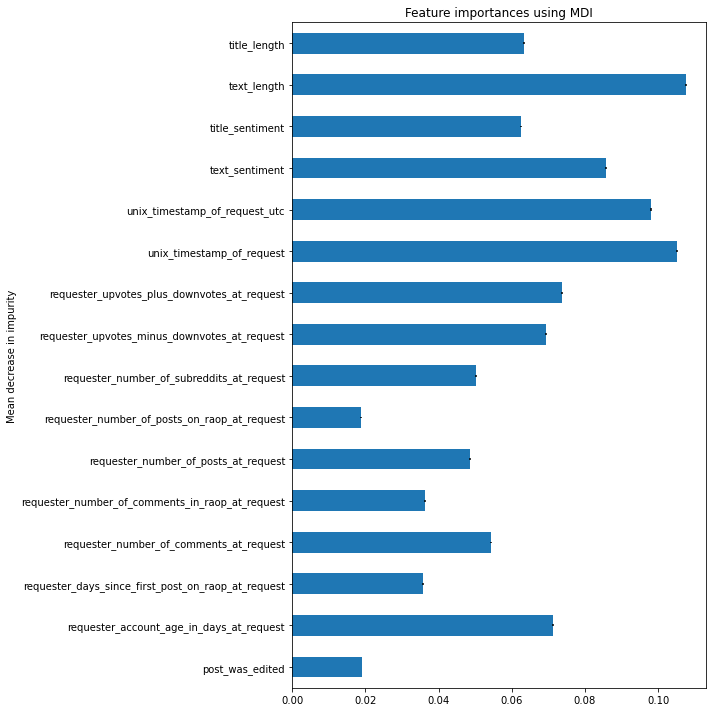

In [100]:
sid = SentimentIntensityAnalyzer()

#use inbuilt sid.polarity_scores to extract scores. Read on for the results
text_analyzed = data['request_text'].apply(lambda request_text: sid.polarity_scores(request_text))
 
#We break the dict generated above and pull only column 'compound'
X['text_sentiment']  = text_analyzed.apply(lambda s : s['compound'])

#use inbuilt sid.polarity_scores to extract scores. Read on for the results
title_analyzed = data['request_title'].apply(lambda request_title: sid.polarity_scores(request_title))
 
#We break the dict generated above and pull only column 'compound'
X['title_sentiment']  = title_analyzed.apply(lambda s : s['compound'])

X['text_length']=data['request_text'].apply(lambda s: len(nltk.word_tokenize(s)))
X['title_length']=data['request_title'].apply(lambda s: len(nltk.word_tokenize(s)))

eval_model(X, plot_importance=True)

In [101]:
documents = []

stop_words = set(stopwords.words('english'))
stemmer = WordNetLemmatizer()

for doc in data['request_text']:
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(doc))    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)     
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document) 
    # Converting to Lowercase
    document = document.lower()    
    #drop stops
    document = document.split()
    document = [word for word in document if word not in stop_words]    
    #lemmatize
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    documents.append(document)

In [102]:
X_2 = X

vectorizer = CountVectorizer(max_features=100, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
request_vec = vectorizer.fit_transform(documents).toarray()

vec_data = pd.merge(X_2, pd.DataFrame(request_vec), left_index=True, right_index=True)
eval_model(vec_data)

CV Model Accuracy: 75.91%
Out of Sample Performance:
[[1006  323]
 [   0    5]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1329
           1       0.02      1.00      0.03         5

    accuracy                           0.76      1334
   macro avg       0.51      0.88      0.45      1334
weighted avg       1.00      0.76      0.86      1334

Calibrated Performance:
[[1004  320]
 [   2    8]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1324
           1       0.02      0.80      0.05        10

    accuracy                           0.76      1334
   macro avg       0.51      0.78      0.45      1334
weighted avg       0.99      0.76      0.86      1334



In [103]:
X_3 = X

tfidfconverter = TfidfTransformer()
tfidf_request = tfidfconverter.fit_transform(request_vec).toarray()

tfidf_data = pd.merge(X_2, pd.DataFrame(request_vec), left_index=True, right_index=True)
eval_model(tfidf_data)


CV Model Accuracy: 75.91%
Out of Sample Performance:
[[1006  324]
 [   0    4]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1330
           1       0.01      1.00      0.02         4

    accuracy                           0.76      1334
   macro avg       0.51      0.88      0.44      1334
weighted avg       1.00      0.76      0.86      1334

Calibrated Performance:
[[1005  320]
 [   1    8]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1325
           1       0.02      0.89      0.05         9

    accuracy                           0.76      1334
   macro avg       0.51      0.82      0.45      1334
weighted avg       0.99      0.76      0.86      1334

